<a href="https://colab.research.google.com/github/dntjr41/CV_TermP/blob/main/cv_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# 경로 지정


In [9]:
%cd drive/My\ Drive/2022_cv_project
!pwd
!ls -la

[Errno 2] No such file or directory: 'drive/My Drive/2022_cv_project'
/content/drive/My Drive/2022_cv_project
/content/drive/My Drive/2022_cv_project
total 3998415
drwx------ 2 root root       4096 May 23 12:43 checkpoints
drwx------ 6 root root       4096 May 23 10:09 cv_project
-rw------- 1 root root      27701 May 23 12:54 cv_project.ipynb
-rw------- 1 root root 4094316129 May 23 09:54 cv_project.zip
drwx------ 3 root root       4096 May 23 12:42 data
drwx------ 3 root root       4096 May 23 12:52 __MACOSX
drwx------ 3 root root       4096 May 23 08:42 model
drwx------ 2 root root       4096 May 23 08:54 outputs
-rw------- 1 root root       1758 May 23 09:48 test.py
-rw------- 1 root root       4716 May 23 09:47 train.py


# 압축 풀기

In [12]:
import tqdm
import zipfile
import os
import glob

# # 폴더 복사 하기
# import shutil
# shutil.copytree('./cv_project', './cv_project_na')

# # 파일 크기 확인
# filepaths = os.listdir('./cv_project/train')
# print(len(filepaths))
# filepaths = os.listdir('./cv_project/val')
# print(len(filepaths))
# filepaths = os.listdir('./cv_project/mask')
# print(len(filepaths))
# filepaths = os.listdir('./cv_project/hint')
# print(len(filepaths))

# 압축 풀기
file_name = 'cv_project_na'
!unzip -qq '{file_name}'

# # 파일 크기 확인
# filepaths = os.listdir('./cv_project_na/train')
# print(len(filepaths))
# filepaths = os.listdir('./cv_project_na/val')
# print(len(filepaths))
# filepaths = os.listdir('./cv_project_na/mask')
# print(len(filepaths))
# filepaths = os.listdir('./cv_project_na/hint')
# print(len(filepaths))

## 더 빠른 GPU

Colab Pro를 사용하여 가장 빠른 GPU에 우선적으로 액세스하세요. Pro+의 경우 더 빠릅니다. 예를 들어 대부분의 표준 Colab 사용자가 속도가 느린 K80 GPU를 수신할 때 Colab Pro 사용자는 T4 또는 P100 GPU를 이용할 수 있습니다. 언제든지 다음 셀을 실행하여 할당된 GPU를 확인할 수 있습니다.

아래 코드 셀의 실행 결과가 ‘Not connected to a GPU’인 경우 메뉴의 런타임 &gt; 런타임 유형 변경에서 런타임을 변경하여 GPU 가속기를 사용 설정한 다음 코드 셀을 다시 실행하면 됩니다.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

## 추가 메모리

<p>Colab Pro를 구독하면 고용량 메모리 VM에 액세스할 수 있습니다&#40;사용 가능한 경우&#41;. Pro+에는 더 많은 메모리가 제공됩니다. 고용량 메모리 런타임을 사용하도록 노트북 환경설정을 지정하려면 런타임 &gt; '런타임 유형 변경' 메뉴를 선택한 다음 런타임 구성 드롭다운에서 고용량 RAM을 선택하세요.</p>
<p>언제든지 다음 코드 셀을 실행하여 사용 가능한 메모리 용량을 확인할 수 있습니다.</p>
아래 코드 셀의 실행 결과가 ‘Not using a high-RAM runtime’인 경우 메뉴의 런타임 &gt; 런타임 유형 변경에서 고용량 RAM 런타임을 사용 설정하고 런타임 구성 드롭다운에서 고용량 RAM을 선택한 다음 코드 셀을 다시 실행하면 됩니다.

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

# Training

device 0 : Tesla P100-PCIE-16GB
train dataset:  40000
validation dataset:  2000
Epoch 1/1
----------


  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([4, 3, 256, 256])) that is different to the input size (torch.Size([4, 1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
100%|██████████| 500/500 [00:50<00:00,  9.92it/s]


 valid Loss: 0.03 
==> best model saved - 0 / 0.0
Training complete in 0m 51s
Best valid Acc: 0 - 0.0


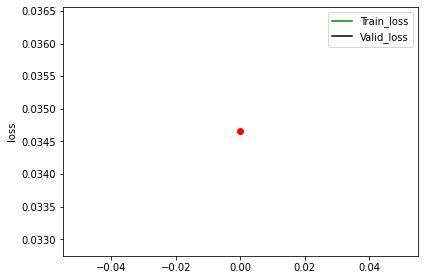

In [ ]:
import os
from data.dataset import ColorHintDataset
import torch.utils.data as data
import torch
import cv2
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from model.res_unet.res_unet import ResUnet
from model.res_unet.res_unet_plus import ResUnetPlusPlus
from model.res_unet.unet import UNet
import matplotlib.image as img
import copy, time

device = "cpu"
if torch.cuda.is_available():
  device = "cuda:0"
  print('device 0 :', torch.cuda.get_device_name(0))


def main():
    # Change to your data root directory
    root_path = "./cv_project"
    os.makedirs('checkpoints/', exist_ok=True)
    check_path = './checkpoints/'
    # Depend on runtime setting
    use_cuda = True

    # Load the data
    train_dataset = ColorHintDataset(root_path, 256, "train")
    val_dataset = ColorHintDataset(root_path, 256, "val")

    dataloaders = {}
    dataloaders['train'] = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
    dataloaders['valid'] = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=True)


    print('train dataset: ', len(train_dataset))
    print('validation dataset: ', len(val_dataset))


    # Select the model
    models = {'ResUnet': ResUnet(3), 'ResUnetPlusPlus': ResUnetPlusPlus(3), 'UNet': UNet()}
    model = models['ResUnet'].to(device)

    criterion = torch.nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    epochs = 1

    # initialize the
    since = time.time()
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 999
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0

            # Iterate over data.
            for i, data in enumerate(tqdm.tqdm(dataloaders[phase])):
                if use_cuda:
                    l = data["l"].to(device)
                    ab = data["ab"].to(device)
                    hint = data["hint"].to(device)
                else:
                    l = data["l"]
                    ab = data["ab"]
                    hint = data["hint"]

                gt_image = torch.cat((l, ab), dim=1)
                hint_image = torch.cat((l, hint), dim=1)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(hint_image)
                    loss = criterion(outputs, gt_image)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.detach().cpu().item()
                num_cnt += len(data)

            # if phase == 'train':
            #     exp_lr_scheduler.step()

            epoch_loss = float(running_loss / num_cnt)

            if phase == 'train':
                train_loss.append(epoch_loss)
            else:
                valid_loss.append(epoch_loss)
            print(' {} Loss: {:.2f} '.format(phase, epoch_loss))

            # deep copy the model
            if phase == 'valid' and epoch_loss < best_loss:
                best_idx = epoch
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                # best_model_wts = copy.deepcopy(model.module.state_dict())

                # Save model & checkpoint
                state = {
                    'epoch': epoch,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                }

                torch.save(model, check_path + str(best_loss) + '_model.pt')
                torch.save(state, check_path + str(best_loss) + '_checkpoint.pt')

                print('==> best model saved - %d / %.1f' % (best_idx, best_loss))

    # Result
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' % (best_idx, best_loss))

    # Save the best model
    torch.save(best_model_wts, check_path + 'best_model.pt')

    # Plot the training result
    fig, ax1 = plt.subplots()
    ax1.plot(train_loss, 'g-', label='Train_loss')
    ax1.plot(valid_loss, 'k-', label='Valid_loss')
    plt.plot(best_idx, valid_loss[best_idx], 'ro')
    ax1.set_ylabel('loss', color='k')
    ax1.tick_params('y', colors='k')
    plt.legend(loc='best')
    fig.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()

# Test

In [ ]:
from data.dataset import ColorHintDataset
import torch
import torch.utils.data as data
import cv2
import tqdm
import os
from data.transform import tensor2im
from model.res_unet.res_unet import ResUnet
from model.res_unet.res_unet_plus import ResUnetPlusPlus
from model.res_unet.unet import UNet

device = "cpu"
if torch.cuda.is_available():
  device = "cuda:0"
  print('device 0 :', torch.cuda.get_device_name(0))
  
def main():
    # Change to your data root directory
    root_path = "./cv_project"
    check_point = './checkpoints/modelname.pt'
    # Depend on runtime setting
    use_cuda = True

    test_dataset = ColorHintDataset(root_path, 256, "test")

    dataloaders = {}
    dataloaders['test'] = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True)

    print('test dataset: ', len(test_dataset))

    model = ResUnetPlusPlus(3).cuda()

    # model = Unet().cuda()
    model.load_state_dict(torch.load(check_point))
    os.makedirs('outputs/predict', exist_ok=True)

    print('test dataset: ', len(dataloaders['test']))

    model.eval()
    for i, data in enumerate(tqdm.tqdm(dataloaders['test'])):
        if use_cuda:
            l = data["l"].to(device)
            ab = data["ab"].to(device)
            hint = data["hint"].to(device)
            mask = data["mask"].to(device)
        else:
            l = data["l"]
            ab = data["ab"]
            hint = data["hint"]
            mask = data["mask"]

        filename = data["file_name"]

        hint_image = torch.cat((l, ab, mask), dim=1)

        output_hint = model(hint_image)
        out_hint_np = tensor2im(output_hint)
        output_bgr = cv2.cvtColor(out_hint_np, cv2.COLOR_LAB2BGR)

        fname = str(filename).replace("['", '')
        fname = fname.replace("']", '')

        cv2.imwrite('./outputs/predict/' + str(fname), output_bgr)

if __name__ == '__main__':
    main()